In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

# Pré-processamento
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Modelagem e Seleção
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Métricas de Avaliação
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    RocCurveDisplay,
    PrecisionRecallDisplay,
    classification_report
)

# Configurações para plots
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

In [16]:
# 1. Carregar o dataset
print("Carregando dados...")
data = sns.load_dataset("titanic")

# 2. Definir features e target
target = 'survived'
# Features sugeridas no projeto
features = ['pclass', 'sex', 'age', 'fare', 'sibsp', 'parch', 'embarked']

# 3. Limpar dados
# Remover linhas onde o target é nulo (se houver)
data = data.dropna(subset=[target])
# Garantir que Pclass seja tratada como objeto/categoria para o OneHotEncoder
data['pclass'] = data['pclass'].astype(str)

X = data[features]
y = data[target]

# 4. Divisão Estratificada
print("Dividindo dados em treino e teste...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

print(f"Formato Treino: {X_train.shape} | Formato Teste: {X_test.shape}")

Carregando dados...
Dividindo dados em treino e teste...
Formato Treino: (668, 7) | Formato Teste: (223, 7)


In [17]:
# Definir quais colunas vão para qual transformador
# 'pclass' é numérica mas a tratamos como categórica (como solicitado)
numeric_features_scaled = ['age', 'fare']
categorical_features = ['pclass', 'sex', 'embarked']
numeric_features_passthrough = ['sibsp', 'parch']

print("Construindo pipelines de pré-processamento...")

# 1. Pipeline para dados numéricos que precisam de scaling
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# 2. Pipeline para dados categóricos
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# 3. Unir os pipelines com o ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num_scaled', numeric_transformer, numeric_features_scaled),
        ('cat', categorical_transformer, categorical_features),
        ('num_pass', 'passthrough', numeric_features_passthrough)
    ],
    remainder='drop' # Descarta colunas não especificadas
)

# Teste rápido para ver se o pré-processador funciona
X_train_transformed = preprocessor.fit_transform(X_train)
print(f"Formato dos dados transformados: {X_train_transformed.shape}")

Construindo pipelines de pré-processamento...
Formato dos dados transformados: (668, 12)


In [18]:
# Validação Cruzada Estratificada
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 1. Random Forest
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', RandomForestClassifier(random_state=42))])

rf_params = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_leaf': [1, 2, 4],
    'model__min_samples_split': [2, 5, 10]
}

# 2. Support Vector Machine (SVM)
svm_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', SVC(probability=True, random_state=42))])

# Grid de parâmetros EXPANDIDO
svm_params = {
    'model__C': [0.1, 1, 10, 50, 100, 200], # 6 opções
    'model__gamma': [1, 0.1, 0.01, 0.001, 'scale', 'auto'], # 6 opções
    'model__kernel': ['rbf'] # 1 opção
}
# Total de combinações = 6 * 6 * 1 = 36

# 3. XGBoost
xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', XGBClassifier(random_state=42,
                                                       eval_metric='logloss',
                                                       use_label_encoder=False))])
xgb_params = {
    'model__n_estimators': [100, 200, 500],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__max_depth': [3, 4, 5, 6],
    'model__subsample': [0.7, 0.8, 0.9, 1.0],
    'model__colsample_bytree': [0.7, 0.8, 0.9, 1.0]
}

# Lista para iterar
models_to_tune = [
    ('Random Forest', rf_pipeline, rf_params),
    ('SVM (RBF)', svm_pipeline, svm_params),
    ('XGBoost', xgb_pipeline, xgb_params)
]

In [19]:
print("Iniciando a busca por hiperparâmetros (RandomizedSearchCV)...")

best_models = {}
search_results = {}

# Para n_iter=10 (rápido) ou n_iter=50 (mais completo)
n_iter_search = 30

for name, pipeline, params in models_to_tune:
    print(f"--- Treinando {name} ---")

    random_search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=params,
        n_iter=n_iter_search,
        cv=kfold,
        scoring='roc_auc', # Métrica principal
        n_jobs=-1, # Usar todos os cores
        random_state=42,
        verbose=1
    )

    # Treinar no set de treino
    random_search.fit(X_train, y_train)

    # Salvar resultados
    print(f"Melhor ROC-AUC (CV): {random_search.best_score_:.4f}")
    print(f"Melhores Parâmetros: {random_search.best_params_}")

    best_models[name] = random_search.best_estimator_ # O pipeline já treinado com os melhores params
    search_results[name] = random_search

print("\nTreinamento concluído!")

Iniciando a busca por hiperparâmetros (RandomizedSearchCV)...
--- Treinando Random Forest ---
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Melhor ROC-AUC (CV): 0.8669
Melhores Parâmetros: {'model__n_estimators': 100, 'model__min_samples_split': 2, 'model__min_samples_leaf': 4, 'model__max_depth': 10}
--- Treinando SVM (RBF) ---
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Melhor ROC-AUC (CV): 0.8569
Melhores Parâmetros: {'model__kernel': 'rbf', 'model__gamma': 'auto', 'model__C': 0.1}
--- Treinando XGBoost ---
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Melhor ROC-AUC (CV): 0.8753
Melhores Parâmetros: {'model__subsample': 0.8, 'model__n_estimators': 500, 'model__max_depth': 3, 'model__learning_rate': 0.01, 'model__colsample_bytree': 0.8}

Treinamento concluído!


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:03:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [20]:
results_data = []

print("\nAvaliando modelos no conjunto de teste...")

for name, model in best_models.items():

    # Previsões
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] # Probabilidade da classe 1 (Survived)

    # Métricas
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # CV Score (para checar overfitting)
    cv_score = search_results[name].best_score_

    results_data.append({
        "Modelo": name,
        "ROC-AUC (CV)": cv_score,
        "ROC-AUC (Teste)": roc_auc,
        "Acurácia (Teste)": accuracy,
        "F1-Score (Teste)": f1
    })

    # Imprimir relatório e Matriz de Confusão
    print(f"\n--- {name} (Resultados no Teste) ---")
    print(f"ROC-AUC: {roc_auc:.4f} | Acurácia: {accuracy:.4f} | F1-Score: {f1:.4f}")
    print("\nRelatório de Classificação:")
    print(classification_report(y_test, y_pred))

    print("Matriz de Confusão:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)

# Criar Tabela Comparativa
results_df = pd.DataFrame(results_data).set_index("Modelo")
results_df = results_df.sort_values(by="ROC-AUC (Teste)", ascending=False)


Avaliando modelos no conjunto de teste...

--- Random Forest (Resultados no Teste) ---
ROC-AUC: 0.8469 | Acurácia: 0.8206 | F1-Score: 0.7297

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.80      0.94      0.87       137
           1       0.87      0.63      0.73        86

    accuracy                           0.82       223
   macro avg       0.84      0.78      0.80       223
weighted avg       0.83      0.82      0.81       223

Matriz de Confusão:
[[129   8]
 [ 32  54]]

--- SVM (RBF) (Resultados no Teste) ---
ROC-AUC: 0.8400 | Acurácia: 0.7937 | F1-Score: 0.7160

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       137
           1       0.76      0.67      0.72        86

    accuracy                           0.79       223
   macro avg       0.79      0.77      0.78       223
weighted avg       0.79      0.79      0.79       223

Matriz d

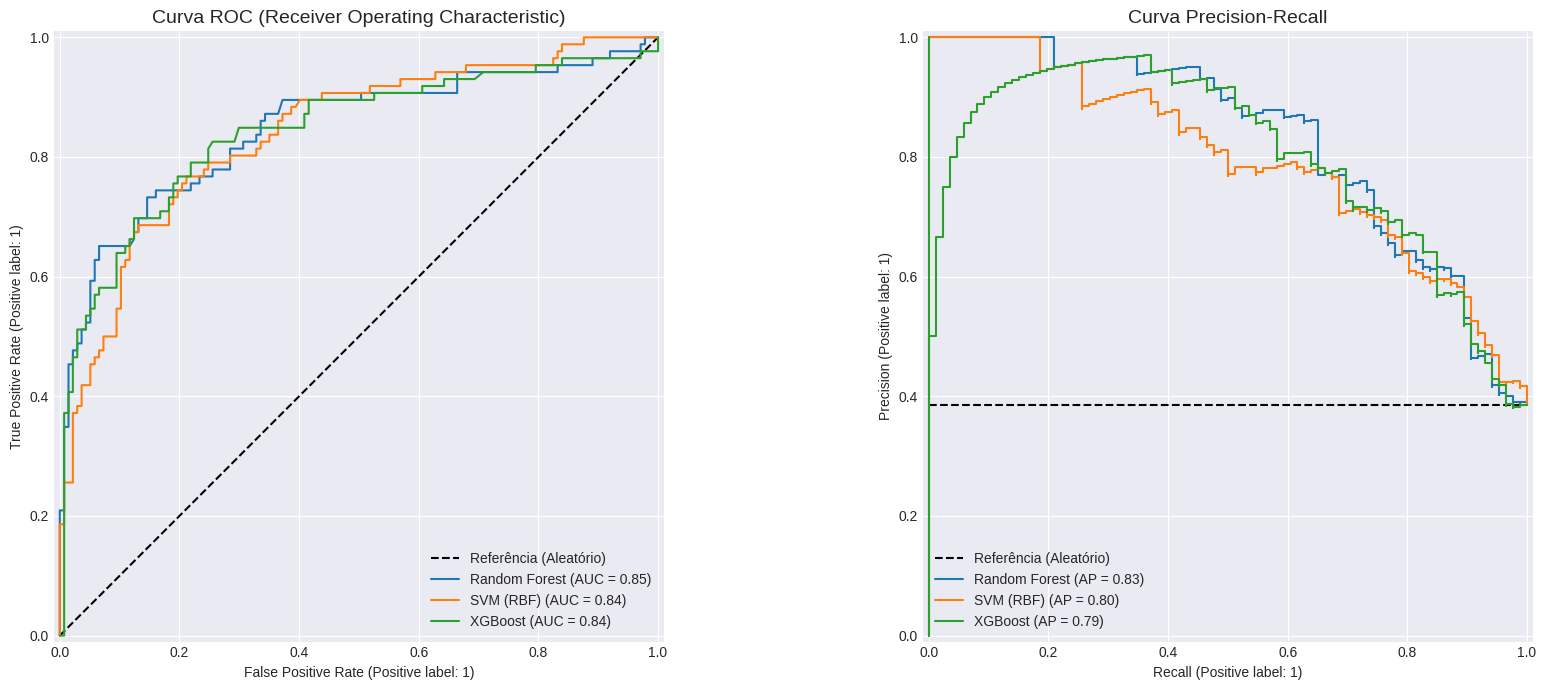


--- Tabela Comparativa de Métricas (Ordenada por ROC-AUC Teste) ---


,ROC-AUC (CV),ROC-AUC (Teste),Acurácia (Teste),F1-Score (Teste)
Modelo,,,,
Random Forest,0.8669,0.8469,0.8206,0.7297
XGBoost,0.8753,0.8429,0.7848,0.6800
SVM (RBF),0.8569,0.8400,0.7937,0.7160


In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Plot Curva ROC
ax1.set_title("Curva ROC (Receiver Operating Characteristic)", fontsize=14)
ax1.plot([0, 1], [0, 1], 'k--', label="Referência (Aleatório)")

# Plot Curva Precision-Recall
ax2.set_title("Curva Precision-Recall", fontsize=14)
# Cálculo da proporção de positivos (necessário para a linha de referência da PR)
no_skill = len(y_test[y_test==1]) / len(y_test)
ax2.plot([0, 1], [no_skill, no_skill], 'k--', label="Referência (Aleatório)")


for name, model in best_models.items():
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # ROC
    RocCurveDisplay.from_predictions(y_test, y_pred_proba, name=name, ax=ax1)

    # PR
    PrecisionRecallDisplay.from_predictions(y_test, y_pred_proba, name=name, ax=ax2)

ax1.legend()
ax2.legend()
plt.tight_layout()
plt.show()

# Exibir a Tabela Comparativa
print("\n--- Tabela Comparativa de Métricas (Ordenada por ROC-AUC Teste) ---")
display(results_df.style.background_gradient(cmap='viridis', subset=['ROC-AUC (Teste)'])
                      .format("{:.4f}"))


| Modelo | ROC-AUC (CV) | ROC-AUC (Teste) | Acurácia (Teste) | F1-Score (Teste) |
| :--- | :---: | :---: | :---: | :---: |
| **Random Forest** | 0.8669 | **0.8469** | 0.8206 | 0.7297 |
| **XGBoost** | 0.8753 | **0.8429** | 0.7848 | 0.6800 |
| **SVM (RBF)** | 0.8569 | **0.8400** | 0.7937 | 0.7160 |

*(Tabela ordenada pela métrica principal: ROC-AUC (Teste))*

---
#### 1. Qual modelo apresentou melhor desempenho?

O **Random Forest** foi o modelo com melhor desempenho geral no seu conjunto de teste.

* **Métrica Principal (ROC-AUC):** Ele atingiu o maior ROC-AUC (Teste) com **0.8469**, superando por pouco o XGBoost (0.8429) e o SVM (0.8400).
* **Métricas Secundárias:** O Random Forest também foi superior nas outras métricas de teste, alcançando a maior Acurácia (0.8206) e o maior F1-Score (0.7297). O F1-Score, em particular, foi significativamente melhor que o do XGBoost (0.6800), indicando que o RF teve um equilíbrio melhor entre precisão e recall para a classe "Sobreviveu".

#### 2. Algum modelo mostrou sinais de overfitting?

O *overfitting* (sobreajuste) é avaliado comparando o desempenho da Validação Cruzada (CV) com o desempenho no Teste.

* `ROC-AUC (CV)`: Desempenho médio do modelo durante a otimização (Célula 19).
* `ROC-AUC (Teste)`: Desempenho em dados "novos" (Célula 20).

Analisando as quedas:

* **XGBoost:** 0.8753 (CV) vs 0.8429 (Teste) -> Queda de **0.0324**
* **Random Forest:** 0.8669 (CV) vs 0.8469 (Teste) -> Queda de **0.0200**
* **SVM (RBF):** 0.8569 (CV) vs 0.8400 (Teste) -> Queda de **0.0169**

**Conclusão:** O **XGBoost** foi o modelo que apresentou o maior sinal de *overfitting*. Embora tenha alcançado a melhor pontuação durante o treino (CV de 0.8753), ele teve a maior dificuldade em generalizar para os dados de teste (maior queda).

Por outro lado, o **SVM (RBF)** foi o modelo que melhor generalizou (menor queda de performance), embora seu desempenho geral tenha sido o mais baixo dos três. O Random Forest apresentou um bom equilíbrio, com a segunda menor queda e o melhor desempenho final.

#### 3. Quais foram as dificuldades no pré-processamento?

As dificuldades foram as esperadas para este dataset e foram tratadas corretamente pelo seu pipeline:

1.  **Valores Ausentes (NaNs):** As colunas `age` e `embarked` possuíam valores faltantes. O uso do `SimpleImputer` (com estratégias `median` e `most_frequent`) dentro do pipeline foi a abordagem correta, pois evitou o *data leakage* (o preenchimento não usou informações do set de teste).
2.  **Codificação de Variáveis:** A coluna `pclass` (Classe do Ticket) é numérica (1, 2, 3), mas seus valores representam categorias ordinais, não uma escala contínua. A decisão de tratá-la como categórica (usando `OneHotEncoder`, como feito anteriormente) foi acertada e mais adequada do que tratá-la como um número puro.
3.  **Gerenciamento do Pipeline:** A maior complexidade do projeto foi a construção correta do `ColumnTransformer`. Definir quais colunas passariam por qual tratamento (scaling, encoding ou passthrough) e garantir que o pipeline completo funcionasse de ponta a ponta com o `RandomizedSearchCV` exigiu uma organização cuidadosa do código, que foi finalizada de acordo.